In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import argparse
import gdreg
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

In [5]:
JOB = "compute_score"
PGEN_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/chr@_v1.SPB.hg19.toy_1K"
LD_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/results/top_1K_chr@.ld.npy"
ANNOT_FILE = "/n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz," + \
    "/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz"
PREFIX_OUT = "/n/groups/price/martin/WES_analysis/toy_1K/results/toy_1K"
RANDOM_SEED = 0
MEMORY = 64
SNP_RANGE = None

In [6]:
sys_start_time = time.time()

###########################################################################################
######                                    Parse Options                              ######
###########################################################################################

# JOB = args.job
# PGEN_FILE = args.pgen_file
# LD_FILE = args.ld_file
# ANNOT_FILE = args.annot_file
# PREFIX_OUT = args.prefix_out
# MEMORY = args.memory
# RANDOM_SEED = args.random_seed
# SNP_RANGE = args.snp_range

# Parse and check arguments
LEGAL_JOB_LIST = ["compute_ld", "compute_score"]
err_msg = "# run_gdreg: --job=%s not supported" % JOB
assert JOB in LEGAL_JOB_LIST, err_msg

if JOB in ["compute_ld"]:
    assert SNP_RANGE is not None, "--snp_range required for --job=%s" % JOB
    DIC_RANGE = gdreg.util.parse_snp_range(SNP_RANGE)

# Print input options
header = gdreg.util.get_cli_head()
header += "Call: run_simulation.py \\\n"
header += "--job %s\\\n" % JOB
header += "--pgen_file %s\\\n" % PGEN_FILE
header += "--ld_file %s\\\n" % LD_FILE
header += "--annot_file %s\\\n" % ANNOT_FILE
header += "--prefix_out %s\\\n" % PREFIX_OUT
header += "--memory %d\\\n" % MEMORY
header += "--random_seed %d\\\n" % RANDOM_SEED
header += "--snp_range %s\n" % SNP_RANGE
print(header)

******************************************************************************
* Gene-level directional effect regression (GDReg)
* Version 0.0.2
* Martin Jinye Zhang
* HSPH / Broad Institute
* MIT License
******************************************************************************
Call: run_simulation.py \
--job compute_score\
--pgen_file /n/groups/price/martin/WES_analysis/toy_1K/chr@_v1.SPB.hg19.toy_1K\
--ld_file /n/groups/price/martin/WES_analysis/toy_1K/results/top_1K_chr@.ld.npy\
--annot_file /n/groups/price/martin/WES_analysis/toy_1K/toy.annot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot.gz,/n/groups/price/martin/WES_analysis/toy_1K/toy.pannot_hr.gz\
--prefix_out /n/groups/price/martin/WES_analysis/toy_1K/results/toy_1K\
--memory 64\
--random_seed 0\
--snp_range None



In [7]:
###########################################################################################
######                                   Data Loading                                ######
###########################################################################################
# Load genotype data
if JOB in ["compute_ld", "compute_score"]:
    print("# Loading --pgen_file")
    dic_data = {}
    for CHR in range(1, 23):
        if os.path.exists(PGEN_FILE.replace("@", "%s" % CHR) + ".pgen"):
            dic_data[CHR] = gdreg.util.read_pgen(PGEN_FILE.replace("@", "%s" % CHR))

    print("    Genotype data for %d CHRs:" % len(dic_data))
    for CHR in dic_data:
        n_sample = dic_data[CHR]["psam"].shape[0]
        n_snp = dic_data[CHR]["pvar"].shape[0]
        mat_X = gdreg.util.read_geno(
            dic_data[CHR]["pgen"], 0, 50, n_sample=None, n_snp=None
        )
        sparsity = (mat_X != 0).mean()
        print(
            "        CHR%2d (%d samples, %d SNPs, %0.1f%% non-zeros for first 50 SNPs)"
            % (CHR, n_sample, n_snp, sparsity * 100)
        )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load LD information
if JOB in ["compute_score"]:
    print("# Loading --ld_file")
    dic_ld = {}
    for CHR in dic_data:
        assert os.path.exists(LD_FILE.replace("@", "%s" % CHR)), (
            "--ld_file missing for CHR%d" % CHR
        )
        dic_ld[CHR] = np.load(LD_FILE.replace("@", "%s" % CHR))
        err_msg = "--ld_file do not match dimension of --pgen_file for CHR%d" % CHR
        assert dic_ld[CHR].shape[0] == dic_data[CHR]["pvar"].shape[0], err_msg
    print("    LD info loaded for %d CHRs." % len(dic_ld))
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load annotation files
if JOB in ["compute_score"]:
    print("# Loading --annot_file")
    df_annot = None
    pannot_list = []
    pannot_hr_list = []
    for annot_file in ANNOT_FILE.split(","):
        assert os.path.exists(annot_file), (
            "--annot_file missing : '%s'" % annot_file
        )
        temp_df = gdreg.util.read_annot(annot_file)

        if annot_file.endswith(".annot.gz"):
            temp_df.index = temp_df["SNP"]
            if df_annot is None:
                df_annot = temp_df.copy()
            else:
                df_annot = df_annot.join(temp_df)
        if annot_file.endswith(".pannot.gz"):
            pannot_list.append(temp_df.copy())
        if annot_file.endswith(".pannot_hr.gz"):
            pannot_hr_list.append(temp_df.copy())
    AN_list = [x for x in df_annot if x.startswith("AN:")]
    print(
        "    .annot.gz file for %s SNPs and %d annotations: %s"
        % (df_annot.shape[0], len(AN_list), ",".join(AN_list))
    )
    temp_list = ["%s (%s SNPs)" % (x.columns[-1], x.shape[0]) for x in pannot_list]
    print(
        "    .pannot.gz files for %d annotations: %s"
        % (len(pannot_list), ",".join(temp_list)),
    )
    temp_list = [
        "%s (%s pairs)" % (x.columns[-1], x.shape[0]) for x in pannot_hr_list
    ]
    print(
        "    .pannot_hr.gz files for %d annotations: %s"
        % (len(pannot_hr_list), ",".join(temp_list)),
    )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Loading --pgen_file
    Genotype data for 10 CHRs:
        CHR 1 (1000 samples, 1400 SNPs, 25.9% non-zeros for first 50 SNPs)
        CHR 2 (1000 samples, 1322 SNPs, 43.1% non-zeros for first 50 SNPs)
        CHR 3 (1000 samples, 1326 SNPs, 33.2% non-zeros for first 50 SNPs)
        CHR 4 (1000 samples, 1341 SNPs, 24.1% non-zeros for first 50 SNPs)
        CHR 5 (1000 samples, 1311 SNPs, 36.9% non-zeros for first 50 SNPs)
        CHR 6 (1000 samples, 1341 SNPs, 38.7% non-zeros for first 50 SNPs)
        CHR 7 (1000 samples, 1375 SNPs, 41.9% non-zeros for first 50 SNPs)
        CHR 8 (1000 samples, 1320 SNPs, 32.8% non-zeros for first 50 SNPs)
        CHR 9 (1000 samples, 1307 SNPs, 40.0% non-zeros for first 50 SNPs)
        CHR10 (1000 samples, 1280 SNPs, 44.0% non-zeros for first 50 SNPs)
    sys_time=1.8s, sys_mem=0.098GB
# Loading --ld_file
    LD info loaded for 10 CHRs.
    sys_time=3.2s, sys_mem=0.16GB
# Loading --annot_file
    .annot.gz file for 13323 SNPs and 3 annotations: 

In [8]:
if JOB == "compute_score":
    df_score = gdreg.score.compute_score(
        dic_data, 
        dic_ld,
        df_annot,
        pannot_list,
        pannot_hr_list,
        verbose = True,
        win_size = 1e6,
    )

# Call: gdreg.score.compute_score
    13323 SNPs from 10 CHRs: CHR1 (1280 SNPs), CHR2 (1280 SNPs), CHR3 (1280 SNPs), CHR4 (1280 SNPs), CHR5 (1280 SNPs), CHR6 (1280 SNPs), CHR7 (1280 SNPs), CHR8 (1280 SNPs), CHR9 (1280 SNPs), CHR10 (1280 SNPs)
    Single-SNP annots : AN:ALL, AN:CHR1, AN:ODD
    SNP-pair annots : pAN:gene, pAN:proxy (hr)
    win_size=1.0MB, memory=128MB


AttributeError: module 'gdreg' has no attribute 'util'

### Test for correctness

In [6]:
# Read in all LD matrices 
dic_ld_full = {}
temp_path = "/n/groups/price/martin/WES_analysis/toy_1K/results/full_ld"
for CHR in range(1,11):
    for CHR_REF in range(1,11):
        dic_ld_full[(CHR,CHR_REF)] = np.load(
            temp_path + '/top_1K_chr%d_chr%d.ld.npy' % (CHR, CHR_REF)
        )
n_sample = 1000

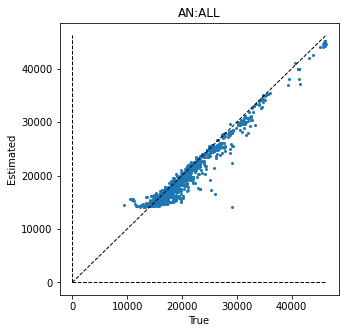

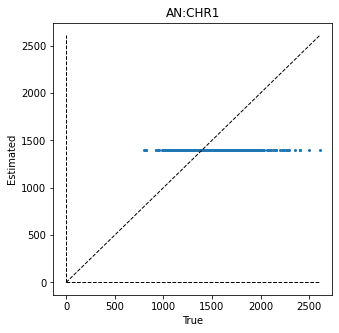

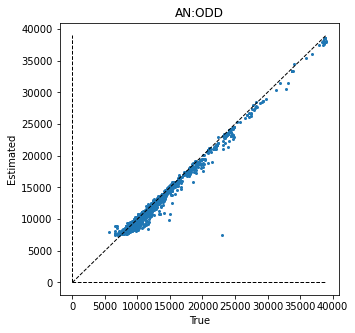

In [7]:
# LD score for CHR1 
CHR = 3
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_ld_score = n_sample * ((mat_ld_chr**2).T*v_annot).sum(axis=1)
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_ld_score, df_score.loc[df_score['CHR']==CHR, 'LD:%s'%AN], s=4)
    x_max = max(v_ld_score.max(), df_score.loc[df_score['CHR']==CHR, 'LD:%s'%AN].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

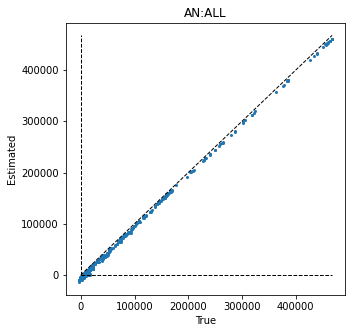

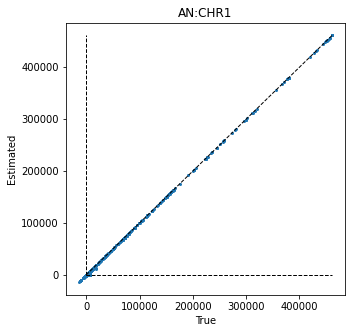

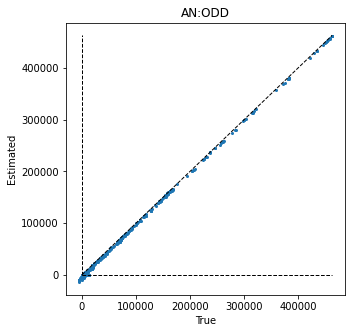

In [8]:
# DLD score using .pannot for CHR1
CHR,pAN = 1,'pAN:gene'
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
mat_S = gdreg.util.pannot_to_csr(pannot_list[0][pAN])
mat_G = mat_S.dot(mat_S.T).toarray()
np.fill_diagonal(mat_G, 0)
                
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_dld_score = 1000* gdreg.score.compute_dld_score(
        mat_ld_chr, mat_G, df_annot[AN].values, np.ones(mat_G.shape[0])
    )
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_dld_score, df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)], s=4)
    x_max = max(v_dld_score.max(), df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

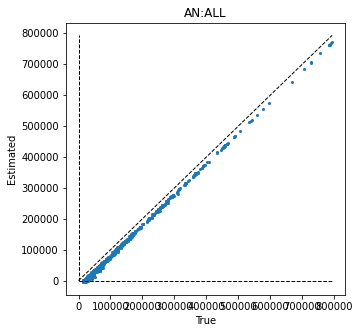

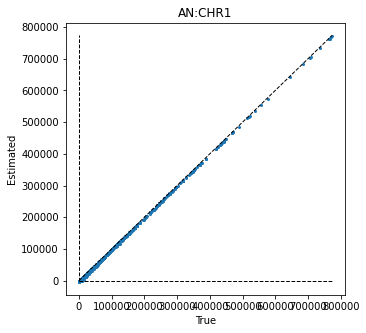

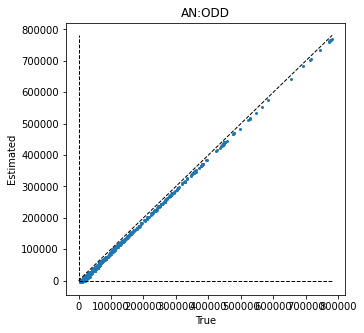

In [9]:
# DLD score using .pannot_hr for CHR1
CHR,pAN = 1,'pAN:proxy'
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
snp_pair_list  = [(x, y) for x, y in zip(pannot_hr_list[0]["SNP"], pannot_hr_list[0]["pSNP"])]
mat_G = gdreg.util.pannot_hr_to_csr(df_annot["SNP"], snp_pair_list)#.toarray()
                
for AN in ['AN:ALL', 'AN:CHR1', 'AN:ODD']:
    v_annot = df_annot[AN].values
    v_dld_score = 1000 * gdreg.score.compute_dld_score(
        mat_ld_chr, mat_G, df_annot[AN].values, np.ones(mat_G.shape[0])
    )
    
    plt.figure(figsize=[5,5])
    plt.scatter(v_dld_score, df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)], s=4)
    x_max = max(v_dld_score.max(), df_score.loc[df_score['CHR']==CHR, 'DLD:%s|%s'%(pAN,AN)].max())
    plt.plot([0, x_max], [0, x_max], '--', color='k', linewidth=1)
    plt.plot([0, x_max], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, x_max], '--', color='k', linewidth=1)
    plt.title(AN)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.show()

### Test for gdreg.score.compute_dld_score

In [184]:
n_snp = 10
n_snp_ref = 50
np.random.seed(0)
mat_ld = np.random.randn(n_snp_ref, n_snp)
mat_G = np.random.choice([0,1], size=[n_snp_ref, n_snp_ref])
mat_G = (mat_G + mat_G.T).astype(bool)
# mat_G = sp.sparse.csr_matrix(mat_G)
v_annot = np.random.randn(n_snp_ref)
v_ps_sd = np.random.rand(n_snp_ref) 

v_score_gold = [
    mat_ld[:,x].reshape([-1,1]).T.dot(
        mat_G * 0.5 * (np.outer(v_annot, np.ones(n_snp_ref)) + np.outer(np.ones(n_snp_ref), v_annot))
        * np.outer(v_ps_sd, v_ps_sd)).dot(
        mat_ld[:,x].reshape([-1,1])
    )[0][0] for x in range(n_snp)
]
v_score_gold = np.array(v_score_gold)

v_score = gdreg.score.compute_dld_score(mat_ld, mat_G, v_annot, v_ps_sd)
print('abs_dif=%0.3g'%np.absolute(v_score_gold - v_score).sum())

v_score = gdreg.score.compute_dld_score(mat_ld, sp.sparse.csr_matrix(mat_G), v_annot, v_ps_sd)
print('abs_dif=%0.3g'%np.absolute(v_score_gold - v_score).sum())

abs_dif=1.22e-14
abs_dif=1.22e-14


### Test for gdreg.score.reg_block_jn

In [106]:
n_sample = 1000
v_beta = np.array([1, 2])
n_rep = 1000
mat_X = np.random.multivariate_normal([0, 0], [[1,-0.5], [-0.5,1]], size=n_sample)

dic_block = {
    0 : [0, 50],
    1 : [50, 200],
    2 : [200, 300],
    3 : [300, 350],
    4 : [350, 450],
    5 : [450, 500],
    6 : [500, 600],
    7 : [600, 1000],
}

mat_coef = np.zeros([n_rep, 2])
ten_cov = np.zeros([n_rep, 2, 2])
for i_rep in range(n_rep):
    np.random.seed(i_rep)
    v_y = mat_X.dot(v_beta) + np.random.randn(n_sample) * 5
    coef_full, coef_mean, coef_cov = gdreg.regress.reg_block_jn(v_y, mat_X, dic_block)
    mat_coef[i_rep, :] = coef_mean
    ten_cov[i_rep, :, :] = coef_cov

print('Estimate:')
print(mat_coef.mean(axis=0))
print('Empi cov:')
print(np.cov(mat_coef.T))
print('JN cov:')
print(ten_cov.mean(axis=0))

Estimate:
[1.00502031 1.99207107]
Empi cov:
[[0.03118544 0.01392717]
 [0.01392717 0.02914277]]
JN cov:
[[0.03139338 0.01407368]
 [0.01407368 0.03214365]]


In [93]:
coef_full, coef_mean, coef_cov = gdreg.regress.reg_block_jn(v_y, mat_X, dic_block, verbose=True)

# Call: gdreg.regress.reg_block_jn
    n_sample=1000, n_regressor=2, n_block=8
